In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import sklearn.decomposition
import sklearn
from mice_dfi import plots
from mice_dfi import dataset

## Load data

In [2]:
# Load CBC features
meta_df_full, features = dataset.load_full_meta(debug=False, signal='blood')
meta_df_full = dataset.filter_CBC_dataset(meta_df_full, features)
peters4_starins = meta_df_full[meta_df_full.label=='Peters4']['strain'].unique()
print(f"Selected {len(peters4_starins)} strains")

# Load body weight and igf1
meta_df_serum, features_serum = dataset.load_full_meta(debug=False, signal='serum')
meta_df_full = meta_df_full.drop(columns=['bw'])
meta_df_full = meta_df_full.merge(meta_df_serum[features_serum.tolist() + ['uid', 'age']], how='left', on=['uid', 'age'])
print("Merged DataFrame shape", meta_df_full.shape)

Loading CBC...
Appending lifespan...
Appending strains mean lifespan...
CGDpheno1 OK
CGDpheno3 OK
Jaxpheno4 OK
Justice2 OK
Lake1 OK
Peters1 OK
Peters2 OK
Peters4 OK
Svenson3 OK
Excluding dataset HMDPpheno5, failed sanity check
Load DataFrame, shape: (6693, 141) outliers removed: 41
Selected 30 strains
Loading serum...
Appending lifespan...
Appending strains mean lifespan...
Merged DataFrame shape (6693, 142)


## Fit data and plot

In [ ]:
fileformat = 'svg'
os.makedirs('./figs',exist_ok=True)  # saving pngs
os.makedirs('./source',exist_ok=True)  # saving source data
bbox_inches = None # None  or 'tight'
production = True
plots.set_style(production=production)
cm = 1/2.54  # centimeters in inches
dpi=300
if production:
    fig_size = 18. / 2 * cm
    fontsize = 7
    scale=0.5
else:
    fig_size = 18. * cm
    fontsize = 16
    scale= 1

Subset: adult, number of animals: 1448
Explained variance adult [31. 19. 16. 12. 11.]
z_0,  r=0.59, p<1e-50 	 z_0,  $R^2$=0.35, p<1e-50
z_1,  r=0.08, p=0.00298 	 z_1,  $R^2$=0.01, p=0.00298
z_2,  r=0.01, p=0.69337 	 z_2,  $R^2$=0.00, p=0.69337
z_3,  r=0.02, p=0.46807 	 z_3,  $R^2$=0.00, p=0.46807
z_4,  r=-0.07, p=0.00597 	 z_4,  $R^2$=0.01, p=0.00597


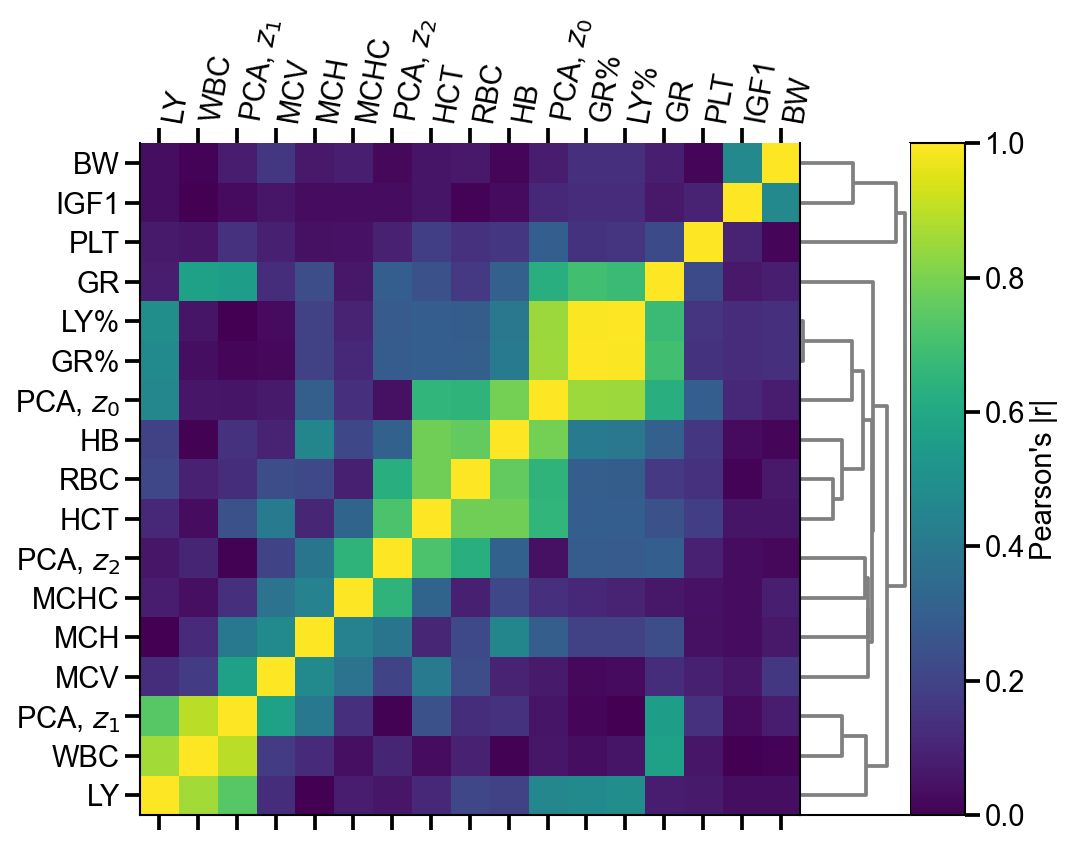

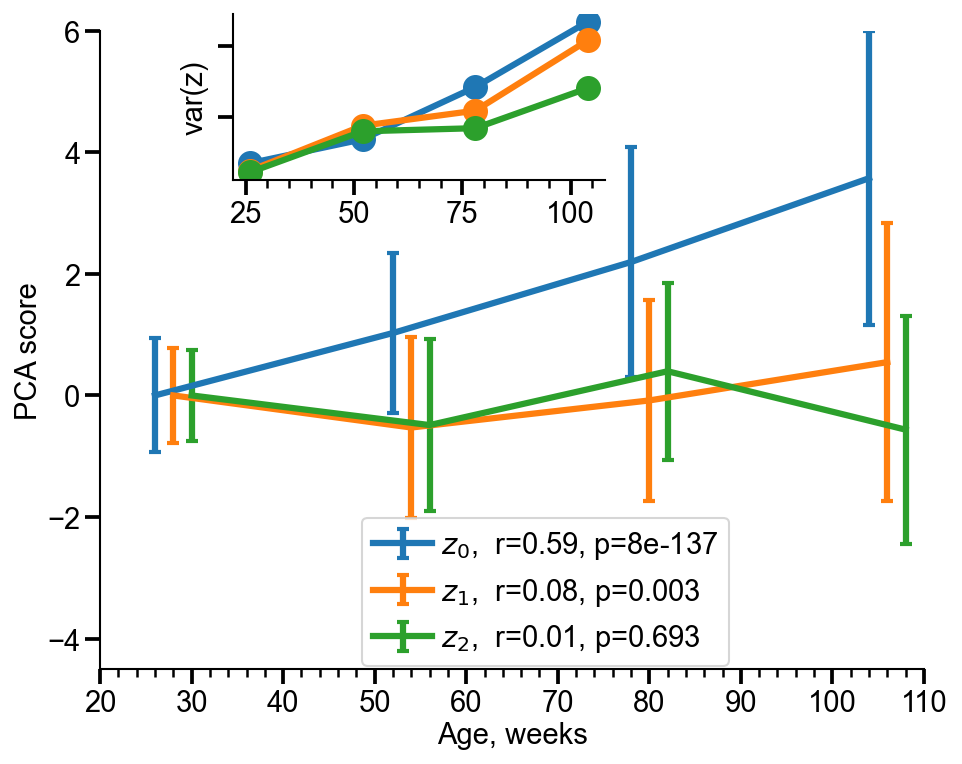

Subset: all, number of animals: 3507
Explained variance all [27. 24. 18. 12. 10.]
z_0,  r=0.48, p<1e-50 	 z_0,  $R^2$=0.23, p<1e-50
z_1,  r=-0.39, p<1e-50 	 z_1,  $R^2$=0.16, p<1e-50
z_2,  r=0.04, p=0.00945 	 z_2,  $R^2$=0.00, p=0.00945
z_3,  r=0.09, p=4e-07 	 z_3,  $R^2$=0.01, p=4e-07
z_4,  r=0.03, p=0.10180 	 z_4,  $R^2$=0.00, p=0.10180


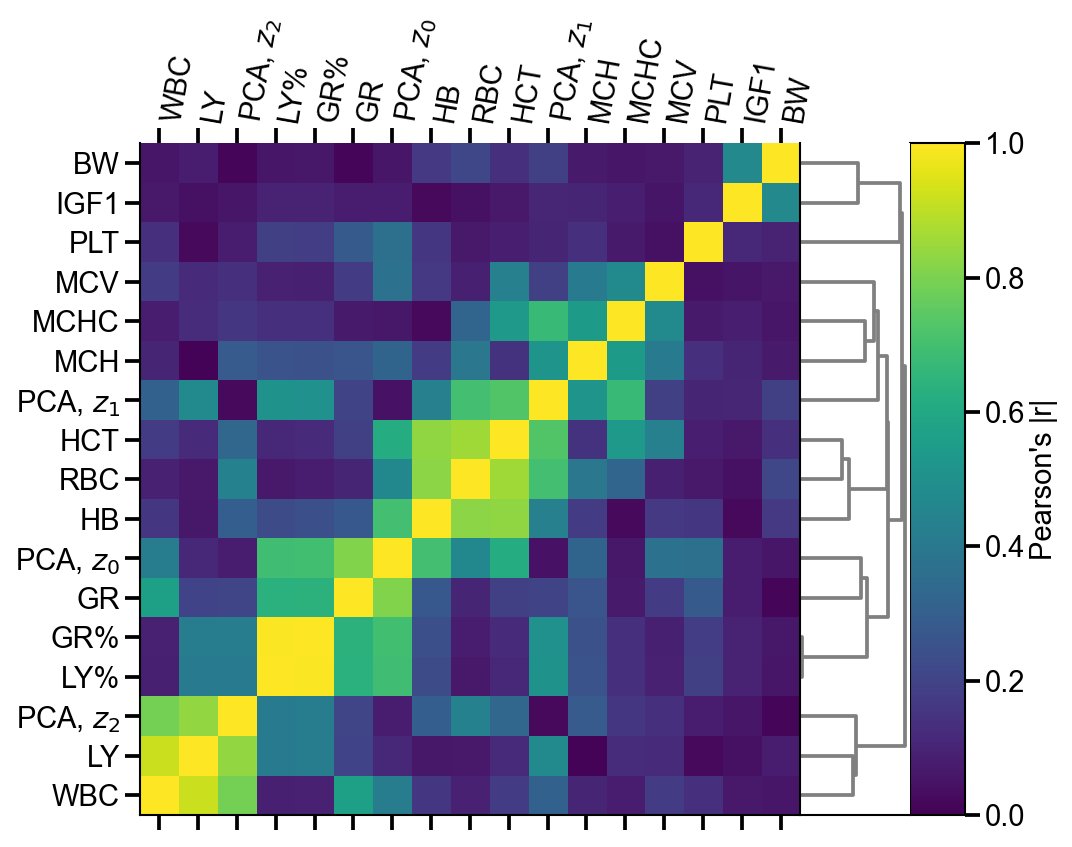

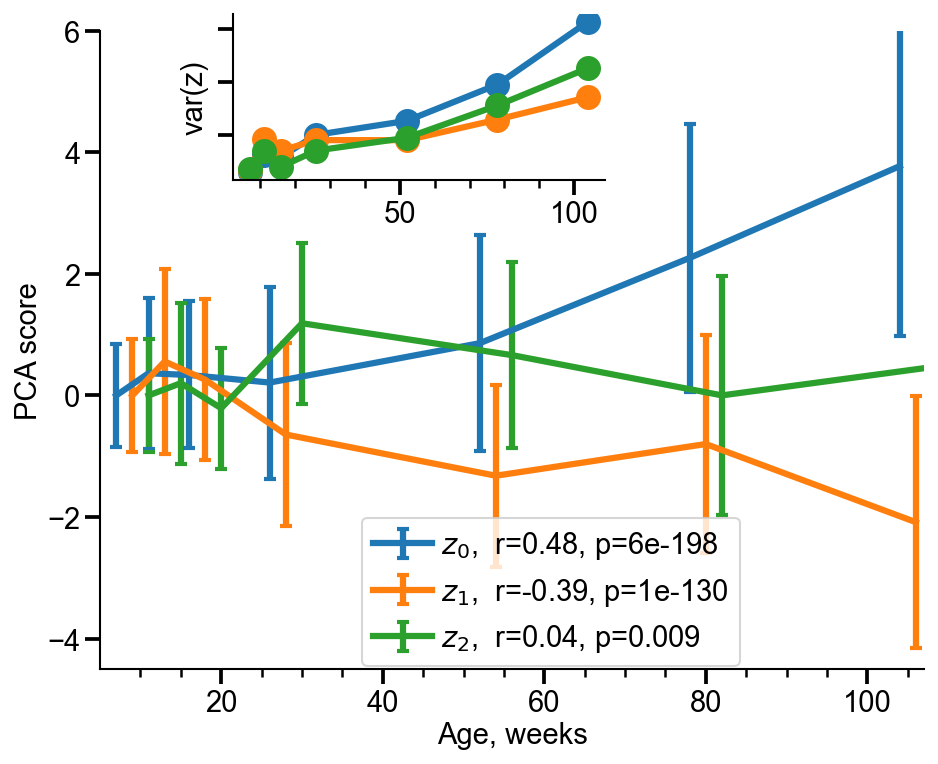

In [4]:
figsize=(fig_size,fig_size*0.78)

meta_df_full['age'] = meta_df_full['age'].replace({8: 7,  14:16})  # reduce number of age point by merging nearest
for full_range in [False, True]:
    if full_range:
        tag = 'all'
        df_ = meta_df_full[meta_df_full.strain.isin(peters4_starins)].copy()
    else:
        tag = 'adult'
        df_ = meta_df_full[(meta_df_full.age >= 25) & (meta_df_full.strain.isin(peters4_starins))].copy()
    df_ = df_.dropna(subset=features)

    # Center each strain and sex at its smallest age
    for gr_, df__ in df_.groupby(['strain', 'sex']):
        mean_ = df__[df__.age==df__.age.min()][features].mean()
        df_.loc[df__.index, features] -= mean_
    df_[features] /= df_[features].std()

    # Fit SVD decomposition
    clsf = sklearn.decomposition.TruncatedSVD(n_components=5, n_iter=10)

    clsf.fit(df_[features].dropna().values)
    svd_scores = clsf.transform(df_[features])
    sort_svd = np.argsort(clsf.explained_variance_ratio_)[::-1]

    print(f"Subset: {tag}, number of animals: {len(df_)}")
    print('Explained variance %s' % tag, np.round(clsf.explained_variance_ratio_[sort_svd]*100))
    for i, j in enumerate(sort_svd):
        key = 'PCA, $z_{:d}$'.format(i)
        df_[key] = svd_scores[:, j]
        print(plots.stats_to_str(df_.age, df_[key], text='z_%d, '% i, stats='cor' ), '\t',
              plots.stats_to_str(df_.age, df_[key], text='z_%d, '% i, stats='r2' ))

    ####################
    ## Plots starts here
    pca_keys = ['PCA, $z_{:d}$'.format(i) for i in range(3)]

    # FIG 1a
    params = np.unique(features).tolist() + ['bw', 'igf1', ] + pca_keys
    params = plots.rename_features(params)
    fig, data, labels = plots.plot_corr_matrix(df_.rename(columns=plots.features_rename_dict), names=params, abs_=True,
                         cmap='viridis', method='single', scale_size=0.7, label="Pearson's |r|", figsize=figsize, dpi=300, fontsize=fontsize)

#     fig.tight_layout()
    fig.savefig('./figs/fig1a_cluster_train_{:s}.{:s}'.format(tag, fileformat), bbox_inches=bbox_inches,  dpi=300)
    plt.show()

    # Save data source for NC submission
    source = pd.DataFrame(data, index=labels, columns=labels)
    try:
        with pd.ExcelWriter('./source/fig1a_cluster.xlsx', engine="openpyxl",  mode="a", if_sheet_exists="replace") as writer:
            source.to_excel(writer, sheet_name='fig1a_cluster_{:s}'.format(tag))
    except FileNotFoundError:
        with pd.ExcelWriter('./source/fig1a_cluster.xlsx', engine="openpyxl") as writer:
            source.to_excel(writer, sheet_name='fig1a_cluster_{:s}'.format(tag))

    ########
    # FIG 1b
    source = {}
    fig = plt.figure(figsize=figsize, dpi=300)
    ax = plt.gca()
    for i, s_ in enumerate(pca_keys):
        df__ = df_[['age', s_]].dropna()
        data_x = df__.groupby(['age'], as_index=False, sort=True).mean()['age'].values
        data_y = df__.groupby(['age'],  sort=True).mean().values.flatten()
        data_yerr = df__.groupby(['age'], sort=True).std().values.flatten()
        source['main_data_x'] = data_x
        source['main_data_y'] = data_y
        source['main_yerr'] = data_yerr
        ax.errorbar(data_x+i*2, data_y, yerr=data_yerr,
                     label=plots.stats_to_str(df__.age, df__[s_], text='$z_%d$, '% i, stats='cor', pdig=3, pcap=1e-300 ),
                     capsize=3*scale, elinewidth=3*scale, lw=3*scale )
    ax.set_xlabel('Age, weeks')
    ax.set_ylabel('PCA score')
    if full_range:
        ax.set_xlim(5, 107)
    else:
        ax.set_xlim(20, 110)
    ax.set_ylim(-4.5, 6.0)
    ax.legend(fontsize=fontsize, loc=2, bbox_to_anchor=(0.3, 0.26), frameon=True,  framealpha=0.8)

    ## add inset with variance
    left, bottom, width, height = [0.25, 0.7, 0.35, 0.2]
    ax2 = fig.add_axes([left, bottom, width, height])

    for i, s_ in enumerate(pca_keys):
        df__ = df_[['age', s_]].dropna()
        data_x = df__.groupby(['age'], as_index=False, sort=True).mean()['age'].values
        data_y = df__.groupby(['age'],  sort=True).var().values.flatten()
        ax2.plot(data_x, data_y, '-o', lw=3*scale)
        source['inset_data_x'] = data_x
        source['inset_data_y'] = data_y

    ax2.set_yticklabels([])
    ax2.set_ylabel('var(z)')

    # Save pngs
#     fig.tight_layout()
    fig.savefig('./figs/fig1a_svd_mpd_{:s}.{:s}'.format(tag, fileformat), bbox_inches=bbox_inches,  dpi=300)
    plt.show()

    # Save data source for NC submission
    source = pd.DataFrame(source)
    try:
        with pd.ExcelWriter('./source/fig1b_pca.xlsx', engine="openpyxl",  mode="a", if_sheet_exists="replace") as writer:
            source.to_excel(writer, sheet_name='fig1b_pca_{:s}'.format(tag))
    except FileNotFoundError:
        with pd.ExcelWriter('./source/fig1b_pca.xlsx', engine="openpyxl") as writer:
            source.to_excel(writer, sheet_name='fig1b_pca_{:s}'.format(tag))
